In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv("Steam_2024_bestRevenue_1500.csv")
df.head()

,name,releaseDate,copiesSold,price,revenue,avgPlaytime,reviewScore,publisherClass,publishers,developers,steamId
0,WWE 2K24,07-03-2024,165301,99.99,8055097.0,42.365140,71,AAA,2K,Visual Concepts,2315690
1,EARTH DEFENSE FORCE 6,25-07-2024,159806,59.99,7882151.0,29.651061,57,Indie,D3PUBLISHER,SANDLOT,2291060
2,Sins of a Solar Empire II,15-08-2024,214192,49.99,7815247.0,12.452593,88,Indie,Stardock Entertainment,"Ironclad Games Corporation,Stardock Entertainment",1575940
3,Legend of Mortal,14-06-2024,440998,19.99,7756399.0,24.797817,76,Indie,"Paras Games,Obb Studio Inc.",Obb Studio Inc.,1859910
4,Shin Megami Tensei V: Vengeance,13-06-2024,141306,59.99,7629252.0,34.258496,96,AA,SEGA,ATLUS,1875830


In [10]:
# Let's find the number of null values
df.isna().sum().sum()

3

##### Since the number of rows with empty values is very small, we can simply exclude them from our analysis

In [11]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1497 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1497 non-null   object 
 1   releaseDate     1497 non-null   object 
 2   copiesSold      1497 non-null   int64  
 3   price           1497 non-null   float64
 4   revenue         1497 non-null   float64
 5   avgPlaytime     1497 non-null   float64
 6   reviewScore     1497 non-null   int64  
 7   publisherClass  1497 non-null   object 
 8   publishers      1497 non-null   object 
 9   developers      1497 non-null   object 
 10  steamId         1497 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 140.3+ KB


# Exploratory Data Analysis

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

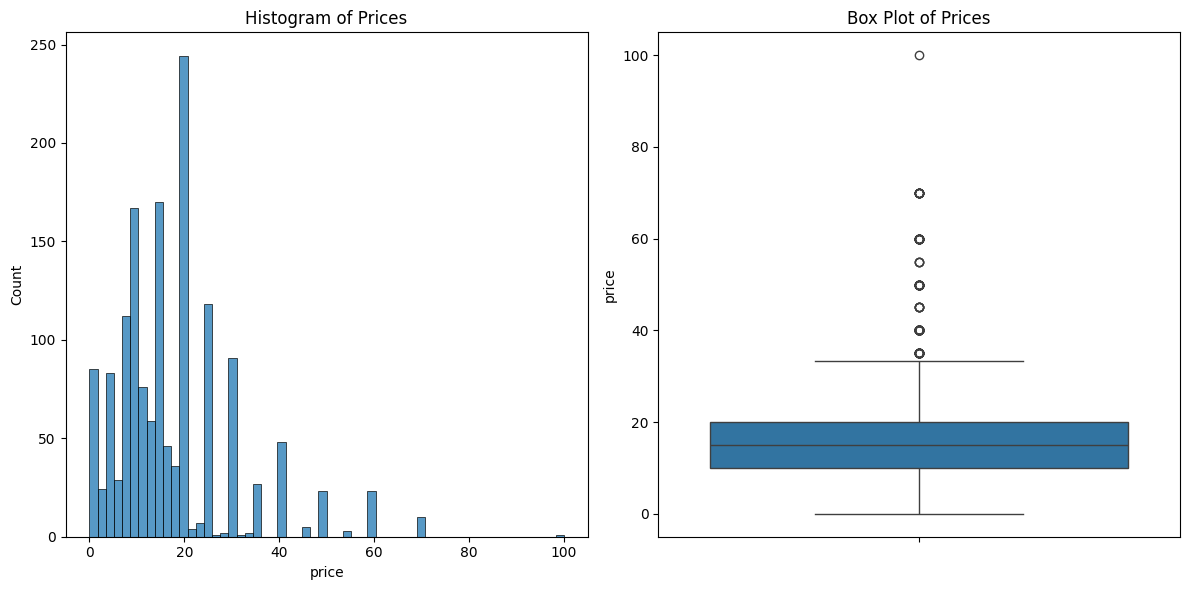

In [13]:
# sns.displot(data=df, x=df['price'], stat='count', bins='auto')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram
sns.histplot(data=df, x='price', stat='count', bins='auto', ax=axes[0])
axes[0].set_title('Histogram of Prices')

# Box Plot
sns.boxplot(data=df, y='price', ax=axes[1])
axes[1].set_title('Box Plot of Prices')

plt.tight_layout()
plt.show()

**We see that the average price of a game is close to 20 dollars**

<Figure size 2400x1200 with 0 Axes>

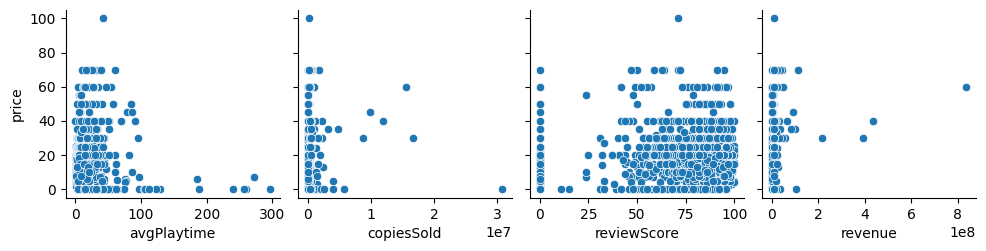

In [14]:
plt.figure(figsize=(24,12))
sns.pairplot(data=df,
                  x_vars=['avgPlaytime', 'copiesSold','reviewScore', 'revenue'],
                  y_vars=['price'],
                  kind="scatter")
plt.show()

**We observe that there is no correlation between any of avgPlaytime, reviewScore, copiesSold, revenue, and price**

In [15]:
df['publishers'].value_counts()

publishers
Kagura Games                     17
Electronic Arts                  16
072 Project                      14
Ubisoft                          13
Mango Party,Mango Party News     11
                                 ..
BLAMCAM Interactive               1
Soda Game Studio                  1
Frogstorm                         1
Significant Steak                 1
Red Nexus Games Inc.,IndieArk     1
Name: count, Length: 1131, dtype: int64

In [16]:
df['publisherClass'].value_counts()


publisherClass
Indie    1299
AA        146
AAA        52
Name: count, dtype: int64

In [17]:
df['developers'].value_counts()


developers
Lust Desires 🖤          9
EA Los Angeles          7
MAGES. Inc.             7
Square Enix             6
CAPCOM Co., Ltd.        5
                       ..
Deathyell Games         1
Fuse Game               1
Demagog Studio          1
Skaule                  1
Red Nexus Games Inc.    1
Name: count, Length: 1405, dtype: int64

# Feature Engineering

In [18]:
# We can remove the steamID and the name as they won't be useful in our analysis

df.drop(columns = ['name','steamId'], inplace=True)
df



,releaseDate,copiesSold,price,revenue,avgPlaytime,reviewScore,publisherClass,publishers,developers
0,07-03-2024,165301,99.99,8055097.0,42.365140,71,AAA,2K,Visual Concepts
1,25-07-2024,159806,59.99,7882151.0,29.651061,57,Indie,D3PUBLISHER,SANDLOT
2,15-08-2024,214192,49.99,7815247.0,12.452593,88,Indie,Stardock Entertainment,"Ironclad Games Corporation,Stardock Entertainment"
3,14-06-2024,440998,19.99,7756399.0,24.797817,76,Indie,"Paras Games,Obb Studio Inc.",Obb Studio Inc.
4,13-06-2024,141306,59.99,7629252.0,34.258496,96,AA,SEGA,ATLUS
...,...,...,...,...,...,...,...,...,...
1495,11-04-2024,452146,24.99,8739530.0,14.494432,73,Indie,Games Operators,Jutsu Games
1496,07-06-2024,2640903,0.00,8706135.0,31.974027,74,Indie,IRONMACE,IRONMACE
1497,20-05-2024,501474,34.99,8641459.0,11.891152,88,AA,Coffee Stain Publishing,Lavapotion
1498,28-08-2024,156339,59.99,8440898.0,14.733899,81,AA,Bandai Namco Entertainment Inc.,"CRAFTS ＆ MEISTER Co., Ltd"


In [19]:
# Before removing the releaseDate column, we may need to find the number of days that have passed since the game was released because the older the game is the lower its' price becomes
df['releaseDate'] = pd.to_datetime(df['releaseDate'], format='%d-%m-%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1497 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   releaseDate     1497 non-null   datetime64[ns]
 1   copiesSold      1497 non-null   int64         
 2   price           1497 non-null   float64       
 3   revenue         1497 non-null   float64       
 4   avgPlaytime     1497 non-null   float64       
 5   reviewScore     1497 non-null   int64         
 6   publisherClass  1497 non-null   object        
 7   publishers      1497 non-null   object        
 8   developers      1497 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 117.0+ KB


In [20]:
# Now, we can add a column that shows how many days have passed since the game's release date
from datetime import datetime

df['days_since_release'] = (datetime.now() - df['releaseDate']).dt.days
df.drop(columns= ['releaseDate'], inplace=True)
df = df.reset_index(drop=True)
df

,copiesSold,price,revenue,avgPlaytime,reviewScore,publisherClass,publishers,developers,days_since_release
0,165301,99.99,8055097.0,42.365140,71,AAA,2K,Visual Concepts,270
1,159806,59.99,7882151.0,29.651061,57,Indie,D3PUBLISHER,SANDLOT,130
2,214192,49.99,7815247.0,12.452593,88,Indie,Stardock Entertainment,"Ironclad Games Corporation,Stardock Entertainment",109
3,440998,19.99,7756399.0,24.797817,76,Indie,"Paras Games,Obb Studio Inc.",Obb Studio Inc.,171
4,141306,59.99,7629252.0,34.258496,96,AA,SEGA,ATLUS,172
...,...,...,...,...,...,...,...,...,...
1492,452146,24.99,8739530.0,14.494432,73,Indie,Games Operators,Jutsu Games,235
1493,2640903,0.00,8706135.0,31.974027,74,Indie,IRONMACE,IRONMACE,178
1494,501474,34.99,8641459.0,11.891152,88,AA,Coffee Stain Publishing,Lavapotion,196
1495,156339,59.99,8440898.0,14.733899,81,AA,Bandai Namco Entertainment Inc.,"CRAFTS ＆ MEISTER Co., Ltd",96


In [21]:
from sklearn.preprocessing import OneHotEncoder

#Extract categorical columns from the dataframe
#Here we extract the columns with object datatype as they are the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)
df_encoded

,copiesSold,price,revenue,avgPlaytime,reviewScore,days_since_release,publisherClass_AA,publisherClass_AAA,publisherClass_Indie,publishers_0 Deer Soft Partnership,...,developers_瞬息万变工作室,developers_筠悦游戏,developers_糯米团子工作室,developers_老乌贼工作室,developers_致意,developers_蒸汽满满工作室,"developers_雪山雞白郎,SnowGBL",developers_零创游戏(ZerocreationGame),developers_雷鸣工作室,developers_香港商河洛互動娛樂股份有限公司
0,165301,99.99,8055097.0,42.365140,71,270,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,159806,59.99,7882151.0,29.651061,57,130,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,214192,49.99,7815247.0,12.452593,88,109,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,440998,19.99,7756399.0,24.797817,76,171,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,141306,59.99,7629252.0,34.258496,96,172,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,452146,24.99,8739530.0,14.494432,73,235,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1493,2640903,0.00,8706135.0,31.974027,74,178,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1494,501474,34.99,8641459.0,11.891152,88,196,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,156339,59.99,8440898.0,14.733899,81,96,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

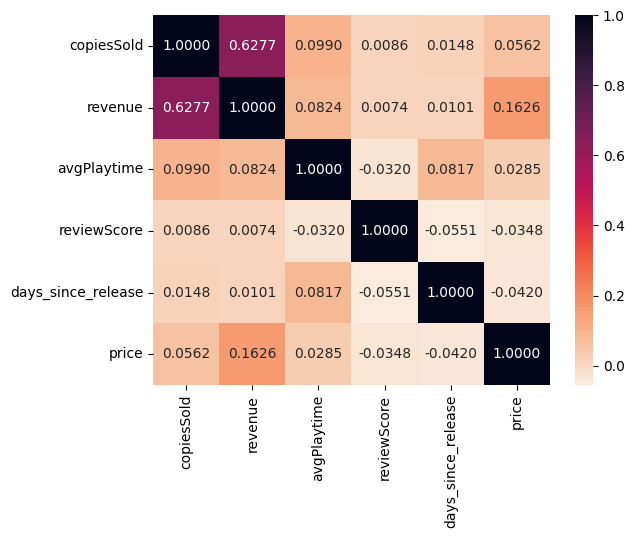

In [22]:
corr = df[['copiesSold', 'revenue','avgPlaytime','reviewScore','days_since_release', 'price']].corr()
#sns.heatmap(corr, annot=True, fmt=".4f", cmap=sns.color_palette("YlOrBr", as_cmap=True))
sns.heatmap(corr, annot=True, fmt=".4f", cmap=sns.color_palette("rocket_r", as_cmap=True))

We observe that the highest correlation between the variables is the correlation between **revenue** and **copiesSold** which **0.6277** which is not very high whereas the rest of the correlations vary between **0.01** and **0.1**. This indicaes that as the number of copies sold increases, the revenue tends to increase as well which is logical of course. 

As for the rest of the variables whose correlations vary between **0.01** and **0.1**, these ones are very small, which suggests that there is little to no linear relationship between those variables. This could indicate that the rest of the variables in this dataset are rather independent from each other or simply that whatever relationship exist between them is non-linear or determined by other factors not captured by the data set.

Overall, aparat from **revenue** and **copiesSold**,this indicates that the variables are linearly independant and we can go ahead and use them in the analysis

# Model Building

## Basic Regression Models

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

features = df_encoded.loc[:, df_encoded.columns != 'price']
target = df_encoded[['price']]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [24]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Make Predictions on the test data
y_pred = reg.predict(X_test)

# Calculate the mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1035.0357669007544
R^2 Score: -5.4684009612199365


This is a relativley high MSE, let's now try the regression with the other regression models that we could use 

In [26]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


def evaluate_data(X_train, y_train, X_test, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "ElasticNet Regression": ElasticNet(),
        "Decision Tree Regressor": DecisionTreeRegressor(),
        "Random Forest Regressor": RandomForestRegressor(),
        "Gradient Boosting Regressor": GradientBoostingRegressor(),
        "Support Vector Regressor": SVR()
    }

    # Train and test each model
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{name} - Mean Squared Error: {mse:.4f} || R^2 Score: {r2:.4f}")

evaluate_data(X_train, y_train, X_test, y_test)

Linear Regression - Mean Squared Error: 1035.0358 || R^2 Score: -5.4684
Ridge Regression - Mean Squared Error: 162.0957 || R^2 Score: -0.0130
Lasso Regression - Mean Squared Error: 145.5896 || R^2 Score: 0.0901
ElasticNet Regression - Mean Squared Error: 152.4495 || R^2 Score: 0.0473
Decision Tree Regressor - Mean Squared Error: 63.9489 || R^2 Score: 0.6004
Random Forest Regressor - Mean Squared Error: 51.5295 || R^2 Score: 0.6780
Gradient Boosting Regressor - Mean Squared Error: 49.5545 || R^2 Score: 0.6903
Support Vector Regressor - Mean Squared Error: 155.2900 || R^2 Score: 0.0295


It appears that the **Gradient Boosting Regressor** algorithm is the best performing model. And from the $R^2$ socre, this model can explain almost **70%** of the data. But let's see if we can improve the model further by applying standardization on the dataset

## Standardize the Dataset

In [27]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['copiesSold', 'revenue','avgPlaytime','reviewScore','days_since_release']
scaler = StandardScaler()

# Transform the data using data normalization on the features

normalized_df = pd.DataFrame(scaler.fit_transform(df_encoded[numeric_features]))
normalized_df.columns = numeric_features

normalized_df = pd.concat([normalized_df,df_encoded['price'], one_hot_df], axis=1)
normalized_df

,copiesSold,revenue,avgPlaytime,reviewScore,days_since_release,price,publisherClass_AA,publisherClass_AAA,publisherClass_Indie,publishers_0 Deer Soft Partnership,...,developers_瞬息万变工作室,developers_筠悦游戏,developers_糯米团子工作室,developers_老乌贼工作室,developers_致意,developers_蒸汽满满工作室,"developers_雪山雞白郎,SnowGBL",developers_零创游戏(ZerocreationGame),developers_雷鸣工作室,developers_香港商河洛互動娛樂股份有限公司
0,0.020782,0.194675,1.381973,-0.213925,0.868427,99.99,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.015934,0.188461,0.792063,-0.789241,-1.188870,59.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.063915,0.186056,-0.005914,0.484673,-1.497464,49.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.264009,0.183942,0.566881,-0.008455,-0.586376,19.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.000387,0.179373,1.005840,0.813425,-0.571681,59.99,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,0.273844,0.219270,0.088823,-0.131737,0.354103,24.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1493,2.204820,0.218070,0.899844,-0.090643,-0.483511,0.00,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1494,0.317362,0.215746,-0.031964,0.484673,-0.219001,34.99,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.012876,0.208539,0.099934,0.197015,-1.688499,59.99,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Now, let's split the data again into a training and a test set

# Caputre the features and the target variables seperatley
features = normalized_df.loc[:, normalized_df.columns != 'price']
target = normalized_df[['price']]

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Evaluate the model on the normalized data
evaluate_data(X_train, y_train, X_test, y_test)

Linear Regression - Mean Squared Error: 749389249373161150467801088.0000 || R^2 Score: -4683268246360065692401664.0000
Ridge Regression - Mean Squared Error: 111.7918 || R^2 Score: 0.3014
Lasso Regression - Mean Squared Error: 145.0933 || R^2 Score: 0.0932
ElasticNet Regression - Mean Squared Error: 152.3424 || R^2 Score: 0.0479
Decision Tree Regressor - Mean Squared Error: 69.8149 || R^2 Score: 0.5637
Random Forest Regressor - Mean Squared Error: 54.4015 || R^2 Score: 0.6600
Gradient Boosting Regressor - Mean Squared Error: 49.9922 || R^2 Score: 0.6876
Support Vector Regressor - Mean Squared Error: 141.1622 || R^2 Score: 0.1178


## MinMaxStandardization

In [29]:
from sklearn.preprocessing import MinMaxScaler

numeric_features = ['copiesSold', 'revenue','avgPlaytime','reviewScore','days_since_release']
scaler = MinMaxScaler()

# Transform the data using data normalization on the features

min_max_df = pd.DataFrame(scaler.fit_transform(df_encoded[numeric_features]))
min_max_df.columns = numeric_features

min_max_df = pd.concat([min_max_df,df_encoded['price'], one_hot_df], axis=1)
min_max_df

,copiesSold,revenue,avgPlaytime,reviewScore,days_since_release,price,publisherClass_AA,publisherClass_AAA,publisherClass_Indie,publishers_0 Deer Soft Partnership,...,developers_瞬息万变工作室,developers_筠悦游戏,developers_糯米团子工作室,developers_老乌贼工作室,developers_致意,developers_蒸汽满满工作室,"developers_雪山雞白郎,SnowGBL",developers_零创游戏(ZerocreationGame),developers_雷鸣工作室,developers_香港商河洛互動娛樂股份有限公司
0,0.005358,0.009590,0.142965,0.71,0.734940,99.99,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005180,0.009384,0.100060,0.57,0.172691,59.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006949,0.009304,0.042022,0.88,0.088353,49.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.014327,0.009234,0.083682,0.76,0.337349,19.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.004578,0.009082,0.115608,0.96,0.341365,59.99,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,0.014690,0.010407,0.048913,0.73,0.594378,24.99,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1493,0.085896,0.010367,0.107899,0.74,0.365462,0.00,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1494,0.016295,0.010290,0.040128,0.88,0.437751,34.99,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.005067,0.010051,0.049721,0.81,0.036145,59.99,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Now, let's split the data again into a training and a test set

# Caputre the features and the target variables seperatley
features = min_max_df.loc[:, min_max_df.columns != 'price']
target = min_max_df[['price']]

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Evaluate the model on the normalized data
evaluate_data(X_train, y_train, X_test, y_test)

Linear Regression - Mean Squared Error: 24631759973467765335513890816.0000 || R^2 Score: -153934873541616467389186048.0000
Ridge Regression - Mean Squared Error: 112.0971 || R^2 Score: 0.2995
Lasso Regression - Mean Squared Error: 144.8032 || R^2 Score: 0.0951
ElasticNet Regression - Mean Squared Error: 152.6473 || R^2 Score: 0.0460
Decision Tree Regressor - Mean Squared Error: 69.0760 || R^2 Score: 0.5683
Random Forest Regressor - Mean Squared Error: 54.4301 || R^2 Score: 0.6598
Gradient Boosting Regressor - Mean Squared Error: 51.6955 || R^2 Score: 0.6769
Support Vector Regressor - Mean Squared Error: 144.7757 || R^2 Score: 0.0952


**From what we see above, it appears that standardization doesn't make a difference in the model performance**

## Hyperparameter Tuning

**Since we observed that standardization of the data did not make any improvements in the model performances, then the next option to be done is Hyperparameter Tuning using both GridSearch and RandomizedSearch on the best performing model and dataset which were the `gradient bossting regressor` and the `standardized dataset`**

In [39]:
features = normalized_df.loc[:, normalized_df.columns != 'price']
target = normalized_df[['price']]

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Initialize the model
gbr = GradientBoostingRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())

# Best parameters and best score
print("Best Parameters (GridSearchCV):", grid_search.best_params_)
print("Best R^2 Score (GridSearchCV):", grid_search.best_score_)

# Evaluate the model on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Mean Squared Error (GridSearchCV): {mean_squared_error(y_test, y_pred):.4f}")
print(f"R^2 Score (GridSearchCV): {r2_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters (GridSearchCV): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best R^2 Score (GridSearchCV): 0.7683627807376301
Mean Squared Error (GridSearchCV): 31.6374
R^2 Score (GridSearchCV): 0.8023


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, scoring='r2', random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train.values.ravel())

# Best parameters and best score
print("Best Parameters (RandomizedSearchCV):", random_search.best_params_)
print("Best R^2 Score (RandomizedSearchCV):", random_search.best_score_)

# Evaluate the model on test data
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)
print(f"Mean Squared Error (RandomizedSearchCV): {mean_squared_error(y_test, y_pred_random):.4f}")
print(f"R^2 Score (RandomizedSearchCV): {r2_score(y_test, y_pred_random):.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (RandomizedSearchCV): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}
Best R^2 Score (RandomizedSearchCV): 0.7694183307088632
Mean Squared Error (RandomizedSearchCV): 33.6704
R^2 Score (RandomizedSearchCV): 0.7896
